In [4]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import wandb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
import pmdarima as pm
import warnings

In [5]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100


In [6]:
# Veriyi yükle ve ön işle
df = pd.read_csv('genel_sunucu_yuku_tum_metrikler.csv', index_col='timestamp')
df.index = pd.to_datetime(df.index, unit='s')

# Veriyi 30 dakikalık aralıklara yeniden örnekle
df_resampled = df.resample('30min').mean().dropna()

# Tahmin edilecek sütunlar
target_columns = ['avg_min_cpu', 'avg_max_cpu', 'avg_avg_cpu']
ts_data = df_resampled[target_columns]

# Veriyi eğitim ve test setlerine ayır (Son 1 gün test verisi)
new_test_size = 48
train_data = ts_data[:-new_test_size]
test_data = ts_data[-new_test_size:]

print("Veri setleri hazır.")
print(f"Eğitim verisi boyutu: {len(train_data)}")
print(f"Test verisi boyutu: {len(test_data)}")


Veri setleri hazır.
Eğitim verisi boyutu: 1392
Test verisi boyutu: 48


--- 'avg_min_cpu' için Durağanlık Testi Sonuçları ---
p-değeri: 1.7166681824975573e-05
Sonuç: Veri durağan görünüyor.
--- 'avg_max_cpu' için Durağanlık Testi Sonuçları ---
p-değeri: 0.024842668677788955
Sonuç: Veri durağan görünüyor.
--- 'avg_avg_cpu' için Durağanlık Testi Sonuçları ---
p-değeri: 0.00032260542222395405
Sonuç: Veri durağan görünüyor.

'avg_avg_cpu' için ACF Grafiği:


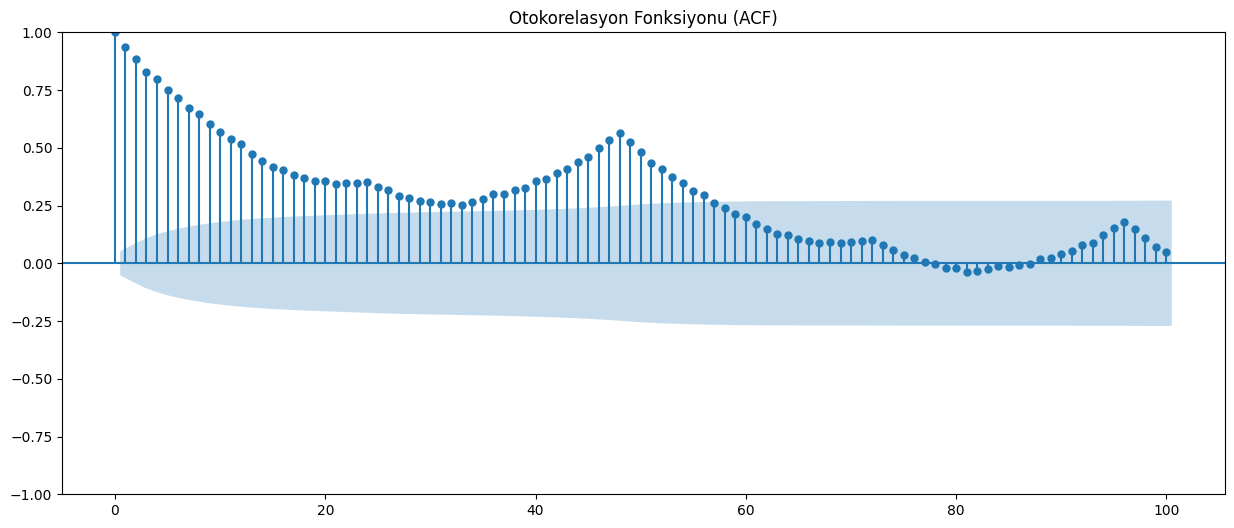

In [7]:
# Bu hücre, model parametrelerini seçmeden önce veriyi anlamamıza yardımcı olur.
# ADF Testi
def adf_test(timeseries, series_name):
    print(f"--- '{series_name}' için Durağanlık Testi Sonuçları ---")
    result = adfuller(timeseries.dropna())
    print(f'p-değeri: {result[1]}')
    if result[1] <= 0.05: print("Sonuç: Veri durağan görünüyor.")
    else: print("Sonuç: Veri durağan değil.")

for column in target_columns:
    adf_test(train_data[column], column)

# ACF Grafiği
print("\n'avg_avg_cpu' için ACF Grafiği:")
plt.rcParams['figure.figsize'] = (15, 6)
plot_acf(train_data['avg_avg_cpu'].dropna(), lags=100)
plt.title("Otokorelasyon Fonksiyonu (ACF)")
plt.show()

In [ ]:
warnings.filterwarnings("ignore", category=FutureWarning)

def run_sarima_experiment(config):
    # 1. WandB Deneyini Başlat
    run = wandb.init(project="bites-cpu-forecasting-final", config=config, reinit=True)
    
    column = config['target_column']
    
    # 2. auto_arima ile en iyi modeli bul ve eğit
    print(f"\n--- Deney Başladı: {run.name} ({column}) ---")
    auto_model = pm.auto_arima(
        train_data[column], m=config['seasonal_period'], seasonal=True, stepwise=True,
        suppress_warnings=True, error_action='ignore', trace=False
    )
    
    print(f"En iyi model bulundu: {auto_model.order} {auto_model.seasonal_order}")
    
    # 3. Tahmin yap
    predictions = auto_model.predict(n_periods=len(test_data))
    
    # 4. Metrikleri hesapla
    y_true = test_data[column].values
    y_pred = predictions.values
    metrics = {
        "final_mae": mean_absolute_error(y_true, y_pred),
        "final_rmse": np.sqrt(mean_squared_error(y_true, y_pred)),
        "final_r2": r2_score(y_true, y_pred),
        "final_mape": mean_absolute_percentage_error(y_true, y_pred)
    }
    
    # 5. Sonuçları WandB'ye logla
    wandb.config.update({
        "best_order": str(auto_model.order),
        "best_seasonal_order": str(auto_model.seasonal_order)
    })
    wandb.log(metrics)
    
    print(f"Metrikler: MAE={metrics['final_mae']:.2f}, R2={metrics['final_r2']:.2f}")
    
    # 6. Deneyi bitir
    run.finish()

In [ ]:
# SARIMA için her bir sütun ayrı bir deneydir.
configs = [
    {'target_column': 'avg_min_cpu'},
    {'target_column': 'avg_max_cpu'},
    {'target_column': 'avg_avg_cpu'}
]

# Tüm deneyler için ortak olan sabit parametreler
base_config = {
    'architecture': 'SARIMA',
    'optimizer': 'auto_arima',
    'seasonal_period': 48
}

# WandB'ye giriş yaptığınızdan emin olun: terminalde 'wandb login'

# Tüm konfigürasyonları sırayla dene
for cfg in configs:
    full_config = {**base_config, **cfg}
    run_sarima_experiment(full_config)